## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00


## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive
drive.mount('/content/drive')

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Mounted at /content/drive


In [ ]:
start_data = "2008-01-01" # import data
start_date = "2010-01-01" # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
MODEL_NAME = "Momentum Strategy"
UNIVERSE = ['SET']

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Screening Conditions

- %Netprofit Growth(%QoQY)1Quater
- RSI(14) > 50
- RSI(14) < 70
- P/E > 0
- D/E < 1
- Average Trading 20 days > 2e7

Ranking: top 10 stock with the highest net profit growth rate

In [ ]:
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')
rsi_df = ssc.ta.rsi(close_df, 14)
pe_df = ssc.get_data(field="pe", timeframe='daily')
de_df = ssc.get_data(field="de", timeframe='quarterly')

net_profit_shift_df = ssc.get_data(field="net_profit", timeframe='quarterly', shift=4)
net_profit_df =  ssc.get_data(field="net_profit", timeframe='quarterly')

net_proft_growth_df = (net_profit_df / net_profit_shift_df)

In [ ]:
# screening condition
rsi_cond = (rsi_df > 50) & (rsi_df > 70)
pe_cond = pe_df > 0
de_cond = de_df < 1

value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = rsi_cond & pe_cond & de_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
# replace values that signal == True
net_proft_growth_df = pd.DataFrame(np.where((signal_df == True)
         , net_proft_growth_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking net profit growth
# 10 highest net profit
pos_num = 10
signal_trade = ssc.rank(
    factor_df=net_proft_growth_df, quantity=pos_num, ascending=False
)  

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

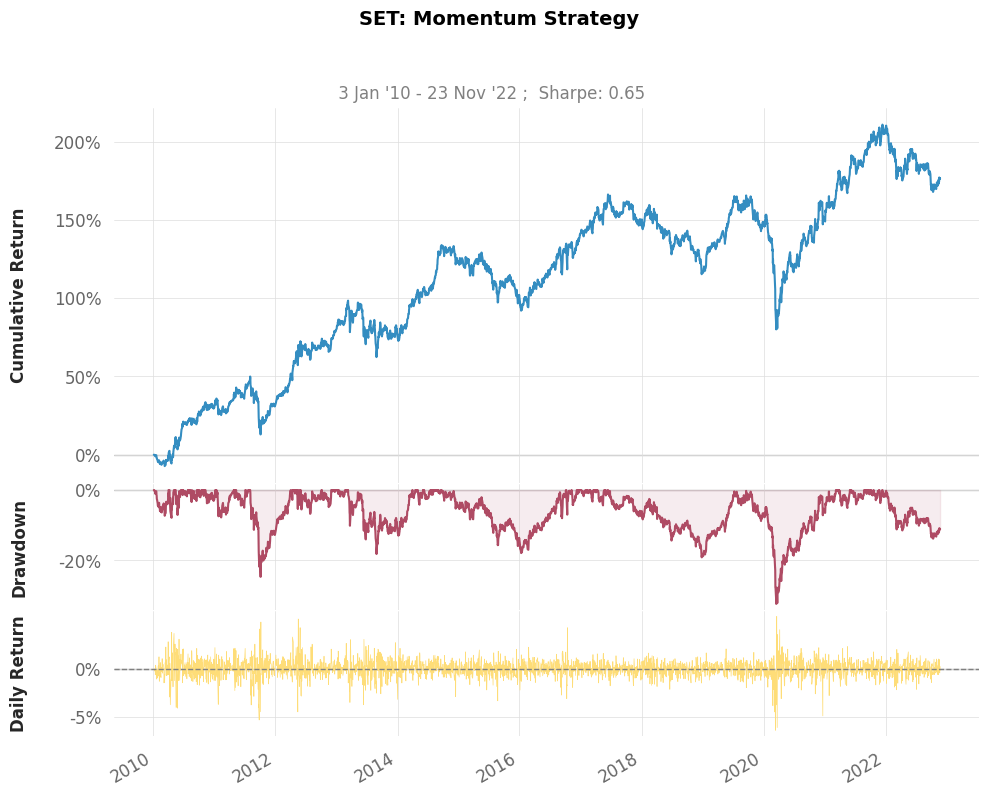

[Performance Metrics]



                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   176.39%     121.83%
CAGR﹪              8.2%        6.37%

Sharpe              0.65        0.47
Prob. Sharpe Ratio  98.81%      95.09%
Sortino             0.91        0.65
Sortino/√2          0.64        0.46
Omega               1.12        1.12

Max Drawdown        -32.38%     -44.29%
Longest DD Days     1365        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.69        0.44

Payoff Ratio        0.91        0.89
Profit Factor       1.12        1.09
Common Sense Ratio  1.15        1.06
CPC Index           0.54        0.52
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.74        3.54
Outlier Loss Ratio  4.2         3.74

MTD                 2.43%       0.97%
3M                  -1.88%      0.

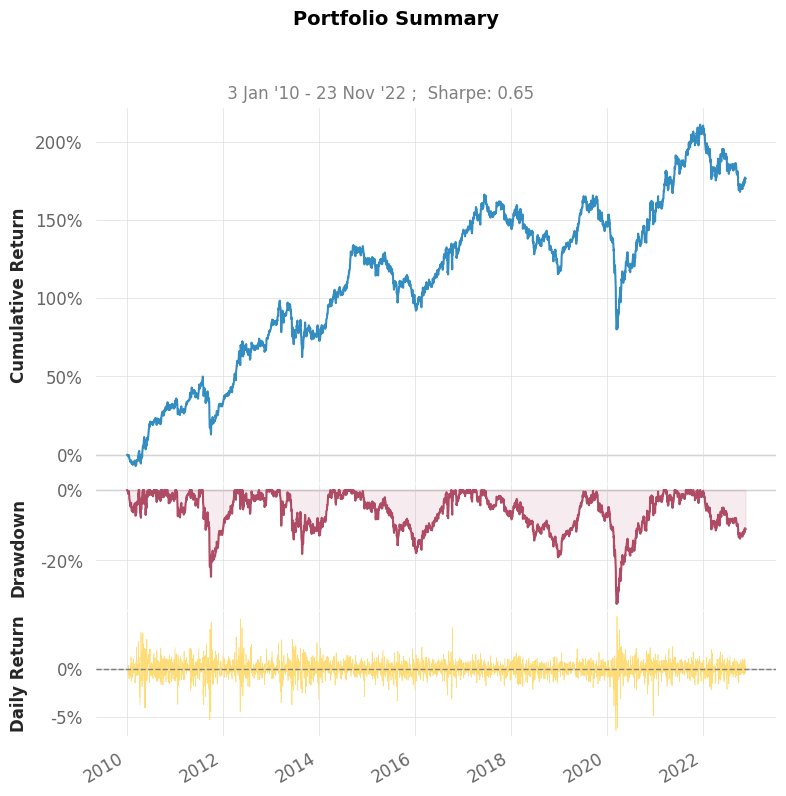

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


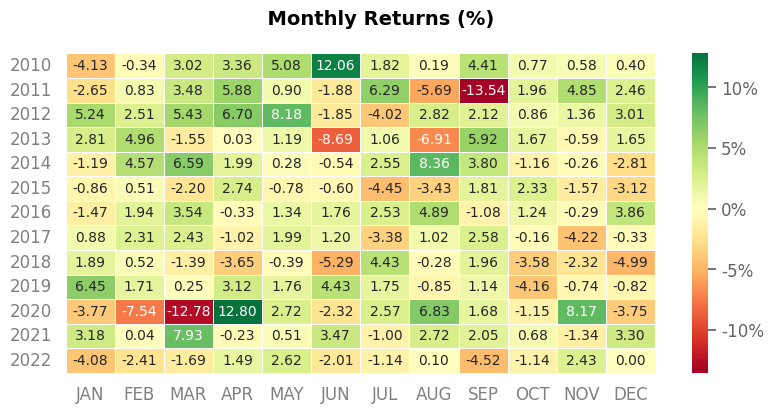

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET50

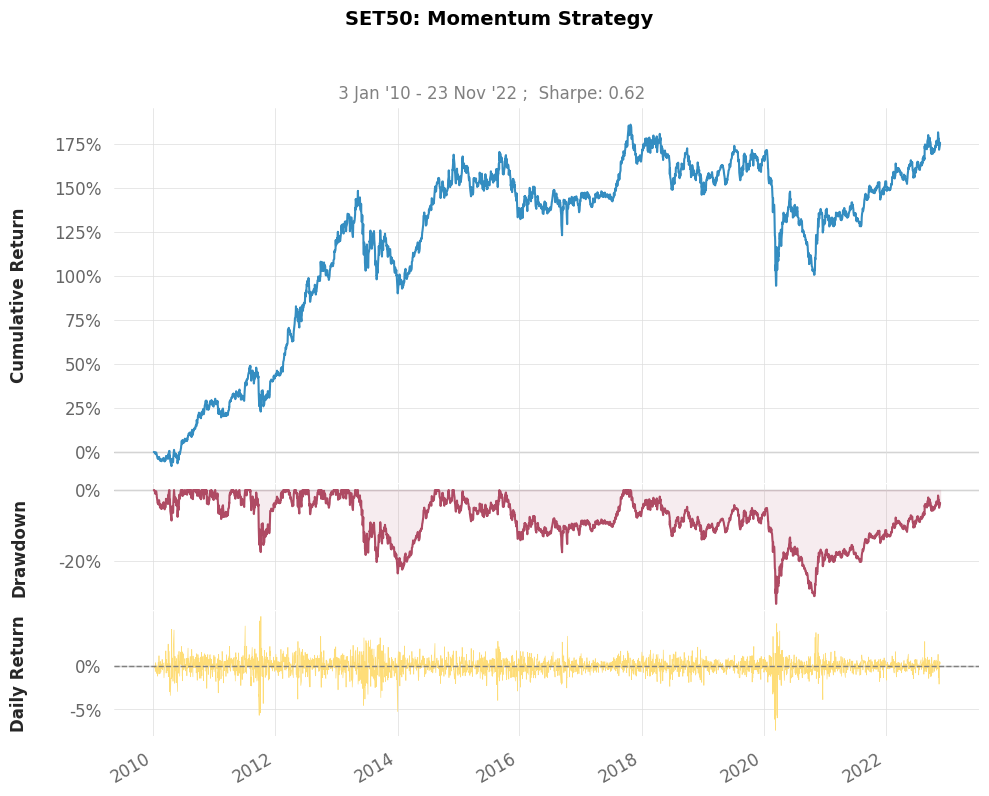

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   175.47%     121.83%
CAGR﹪              8.18%       6.37%

Sharpe              0.62        0.47
Prob. Sharpe Ratio  98.47%      95.09%
Sortino             0.87        0.65
Sortino/√2          0.62        0.46
Omega               1.12        1.12

Max Drawdown        -32.01%     -44.29%
Longest DD Days     1850        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.69        0.44

Payoff Ratio        0.96        0.92
Profit Factor       1.12        1.09
Common Sense Ratio  1.19        1.06
CPC Index           0.56        0.54
Tail Ratio          1.06        0.97
Outlier Win Ratio   3.67        3.64
Outlier Loss Ratio  4.02        3.68

MTD                 0.31%       0.97%
3M         

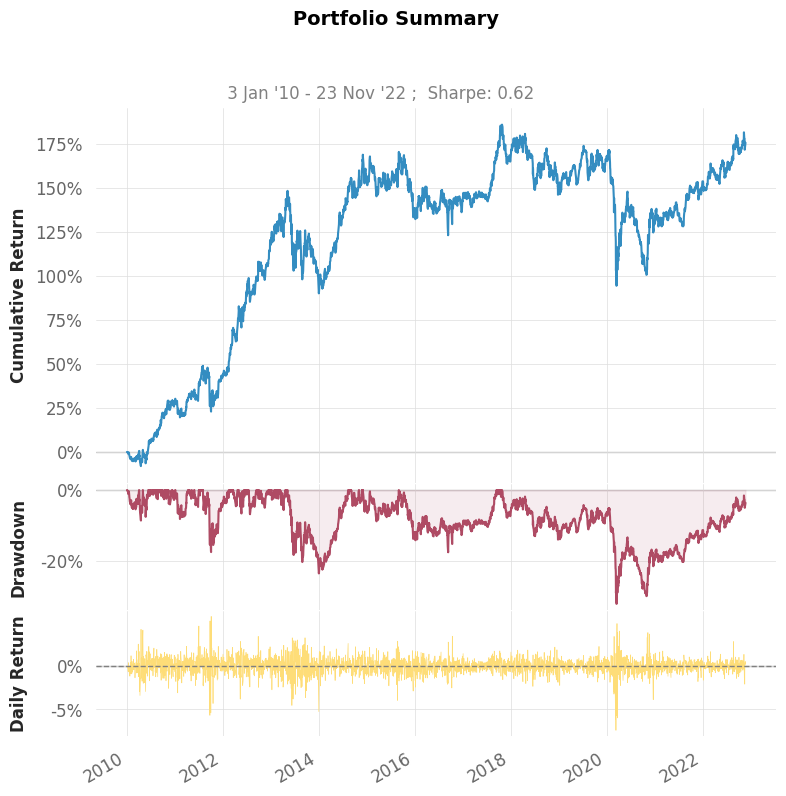

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


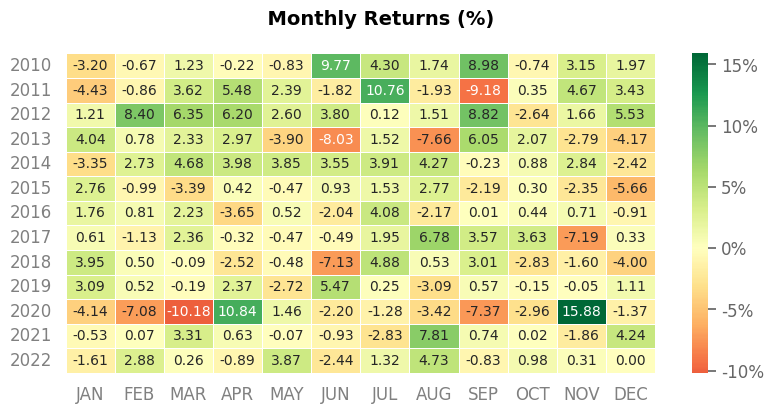

In [ ]:
MODEL_NAME = "Momentum Strategy"
UNIVERSE = ['SET50']

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')
rsi_df = ssc.ta.rsi(close_df, 14)
pe_df = ssc.get_data(field="pe", timeframe='daily')
de_df = ssc.get_data(field="de", timeframe='quarterly')

net_profit_shift_df = ssc.get_data(field="net_profit", timeframe='quarterly', shift=4)
net_profit_df =  ssc.get_data(field="net_profit", timeframe='quarterly')

net_proft_growth_df = (net_profit_df / net_profit_shift_df)
# screening condition
rsi_cond = (rsi_df > 50) & (rsi_df > 70)
pe_cond = pe_df > 0
de_cond = de_df < 1
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7 

signal_cond = rsi_cond & pe_cond & de_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
net_proft_growth_df = pd.DataFrame(np.where((signal_df == True)
         , net_proft_growth_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking net profit growth
# 10 highest net profit
pos_num = 10
signal_trade = ssc.rank(
    factor_df=net_proft_growth_df, quantity=pos_num, ascending=False
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])



# SET100

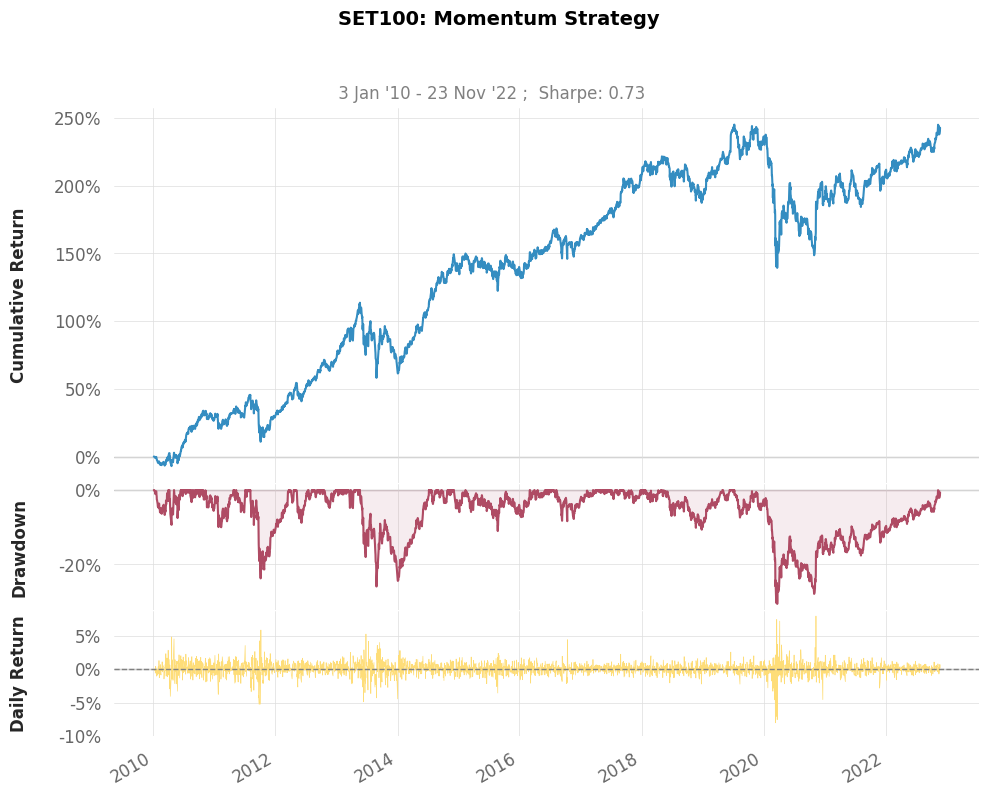

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   242.82%     121.83%
CAGR﹪              10.03%      6.37%

Sharpe              0.73        0.47
Prob. Sharpe Ratio  99.46%      95.09%
Sortino             1.04        0.65
Sortino/√2          0.74        0.46
Omega               1.14        1.14

Max Drawdown        -30.65%     -44.29%
Longest DD Days     1231        1763

Gain/Pain Ratio     0.14        0.09
Gain/Pain (1M)      0.83        0.44

Payoff Ratio        0.96        0.91
Profit Factor       1.14        1.09
Common Sense Ratio  1.16        1.06
CPC Index           0.58        0.54
Tail Ratio          1.01        0.97
Outlier Win Ratio   3.65        3.57
Outlier Loss Ratio  4.22        3.83

MTD                 2.18%       0.97%
3M         

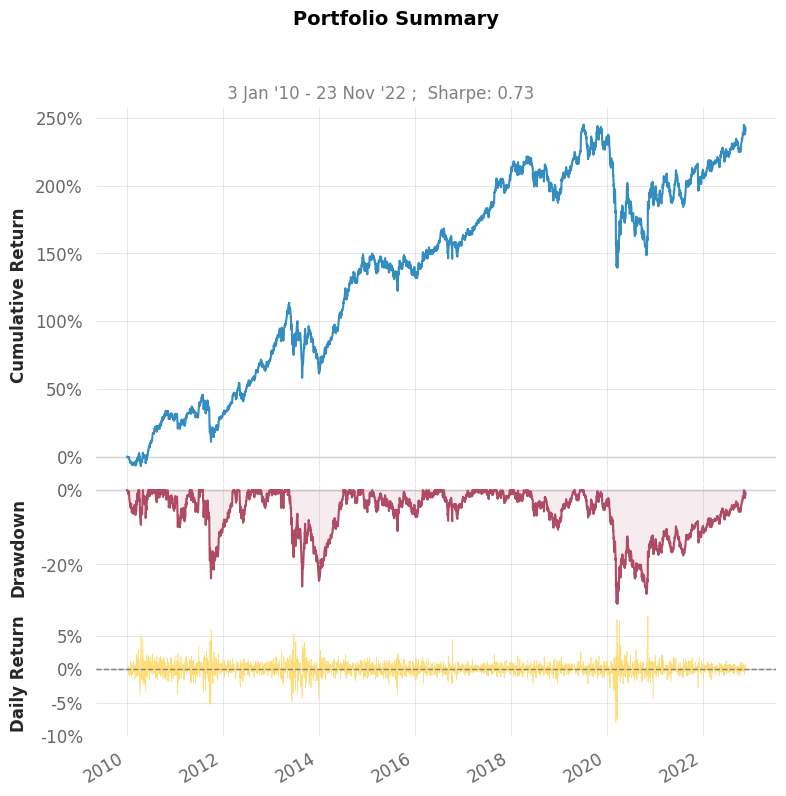

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


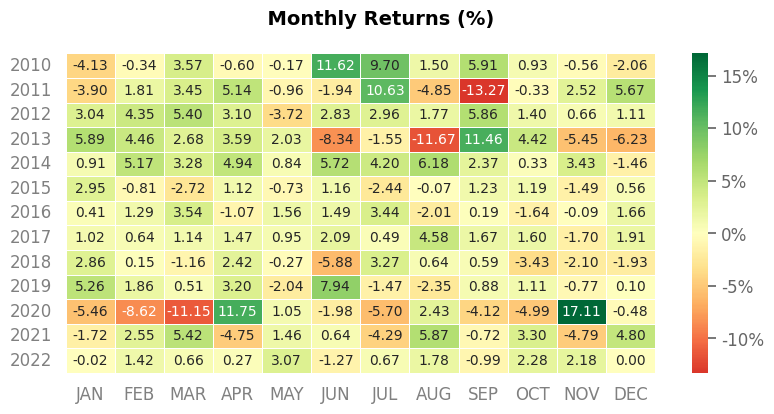

In [ ]:
MODEL_NAME = "Momentum Strategy"
UNIVERSE = ['SET100']

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions

close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')
rsi_df = ssc.ta.rsi(close_df, 14)
pe_df = ssc.get_data(field="pe", timeframe='daily')
de_df = ssc.get_data(field="de", timeframe='quarterly')

net_profit_shift_df = ssc.get_data(field="net_profit", timeframe='quarterly', shift=4)
net_profit_df =  ssc.get_data(field="net_profit", timeframe='quarterly')

net_proft_growth_df = (net_profit_df / net_profit_shift_df)
# screening condition
rsi_cond = (rsi_df > 50) & (rsi_df > 70)
pe_cond = pe_df > 0
de_cond = de_df < 1
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7 

signal_cond = rsi_cond & pe_cond & de_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
net_proft_growth_df = pd.DataFrame(np.where((signal_df == True)
         , net_proft_growth_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking net profit growth
# 10 highest net profit
pos_num = 10
signal_trade = ssc.rank(
    factor_df=net_proft_growth_df, quantity=pos_num, ascending=False
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

